## Baseline models

In [28]:
import dataloader
import DataDLC
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import importlib
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

In [29]:
importlib.reload(dataloader)
importlib.reload(DataDLC)

<module 'DataDLC' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\DataDLC.py'>

**Load DMD_null male dataset**

In [30]:
# Deactivate warnings
import warnings
warnings.filterwarnings('ignore')

data_loader = dataloader.DLCDataLoader(r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models', batch_size=1, num_workers=1, device = 'cpu', build_graph=False)

['DMD_mal_Test_10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_12DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_13DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_14DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_15DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_16DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_17DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_18DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_19DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_20DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_21

#### Split the trainning and test dataset

In [31]:
dataset = data_loader.data_list


In [32]:
# behaviour names
beh_names = dataset[0][1].columns
beh_names

Index(['General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R',
       'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V',
       'Rearing_V', 'Grooming_V'],
      dtype='object')

In [33]:

y = []
coords_dmd_null = []
behaviour = []

for i in tqdm.tqdm(range(len(dataset)-1)):

    ### Prepare a dataset wich is simply all the points concatenated
    n_frames, n_features_coords = dataset[i][0].values.shape
    n_bp_tot = n_features_coords // 3 # 3 coordinates per body part (body parts of both individuals)
    coords = dataset[i][0].values.reshape(n_frames*n_bp_tot, 3) # Only to treat NANs

    has_nan = np.isnan(coords).any(axis=1)
    coords[has_nan, :] = [0, 0, 0]
    coords = coords.reshape(n_frames, n_features_coords) # Back to the original shape

    if coords.shape[0] != dataset[i][1].shape[0]:
        print("Warrning: ", i, " ", coords.shape[0], " ", dataset[i][1].shape[0])
    coords_dmd_null.append(coords)
    behaviour.append(dataset[i][1].to_numpy())

100%|██████████| 58/58 [00:00<00:00, 195.88it/s]


In [34]:
y = np.concatenate(behaviour)
X = np.concatenate(coords_dmd_null)

In [35]:
print(X.shape)
print(y.shape)

(152647, 108)
(152647, 11)


In [36]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [37]:
bodyparts = dataset[0][0].columns.levels[1]
bodyparts

Index(['Center', 'Center_head', 'Left_bhip', 'Left_ear', 'Left_fhip',
       'Left_mid', 'Nose', 'Right_bhip', 'Right_ear', 'Right_fhip',
       'Right_mid', 'Spine_1', 'Spine_1-center', 'Spine_2', 'Spine_2-base',
       'Spine_center-2', 'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4', 'Tail_base',
       'Tail_tip', 'Center of mass'],
      dtype='object', name='bodyparts')

In [38]:
doble_bp = np.concatenate([bodyparts, bodyparts])
doble_bp

array(['Center', 'Center_head', 'Left_bhip', 'Left_ear', 'Left_fhip',
       'Left_mid', 'Nose', 'Right_bhip', 'Right_ear', 'Right_fhip',
       'Right_mid', 'Spine_1', 'Spine_1-center', 'Spine_2',
       'Spine_2-base', 'Spine_center-2', 'Tail_1', 'Tail_2', 'Tail_3',
       'Tail_4', 'Tail_base', 'Tail_tip', 'Center of mass', 'Center',
       'Center_head', 'Left_bhip', 'Left_ear', 'Left_fhip', 'Left_mid',
       'Nose', 'Right_bhip', 'Right_ear', 'Right_fhip', 'Right_mid',
       'Spine_1', 'Spine_1-center', 'Spine_2', 'Spine_2-base',
       'Spine_center-2', 'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
       'Tail_base', 'Tail_tip', 'Center of mass'], dtype=object)

Checking outliers


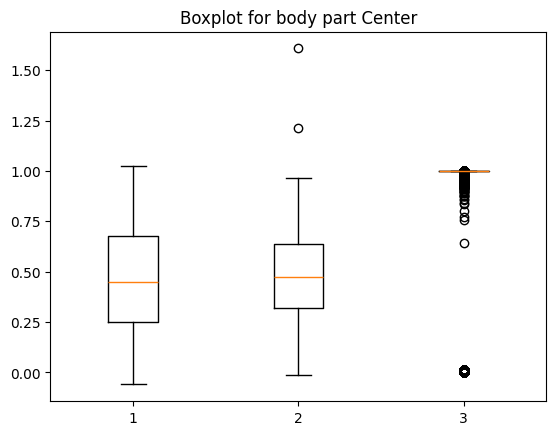

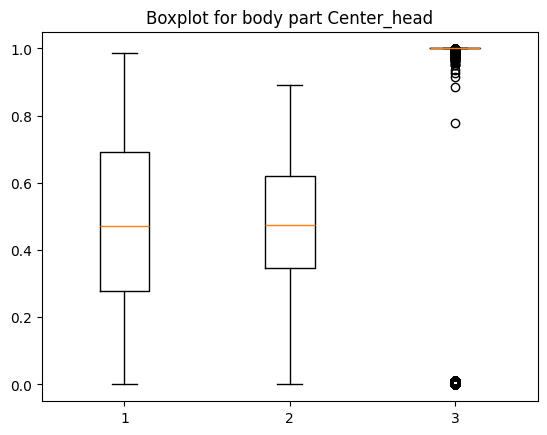

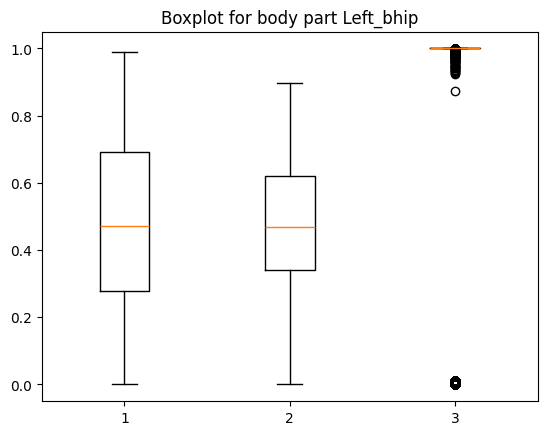

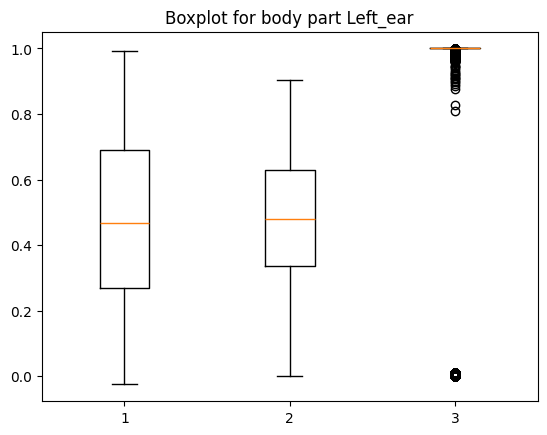

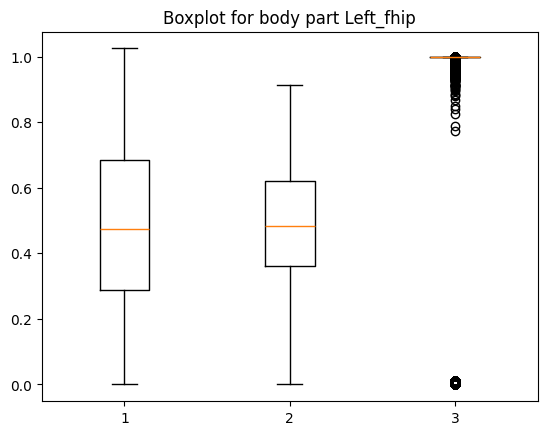

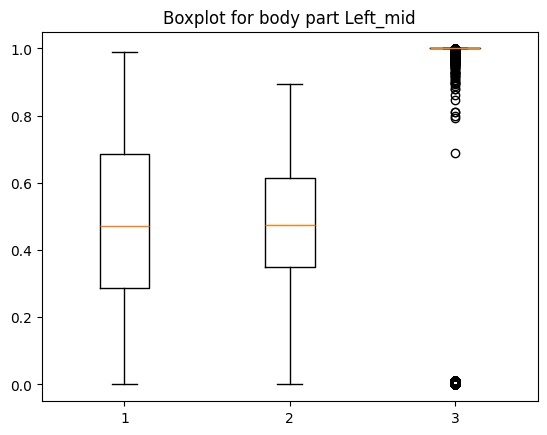

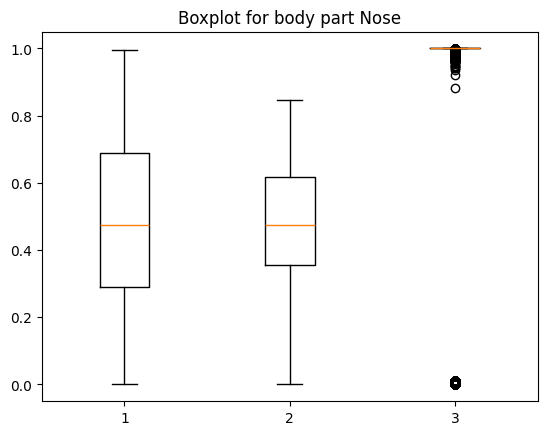

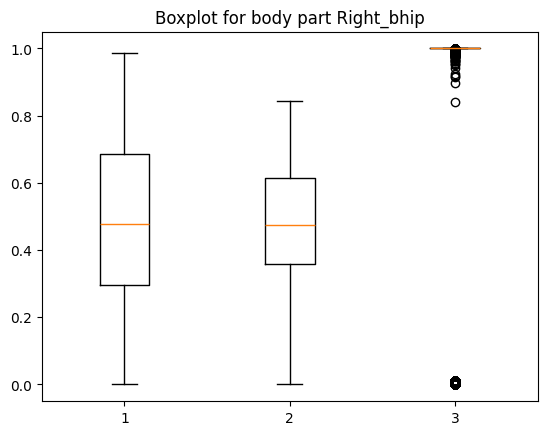

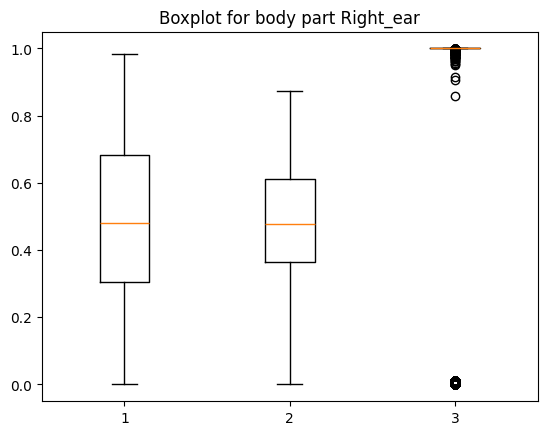

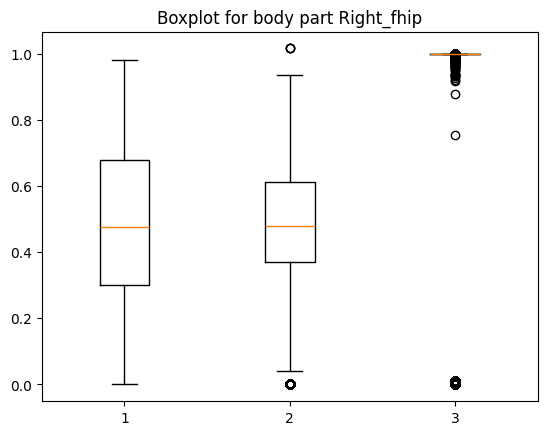

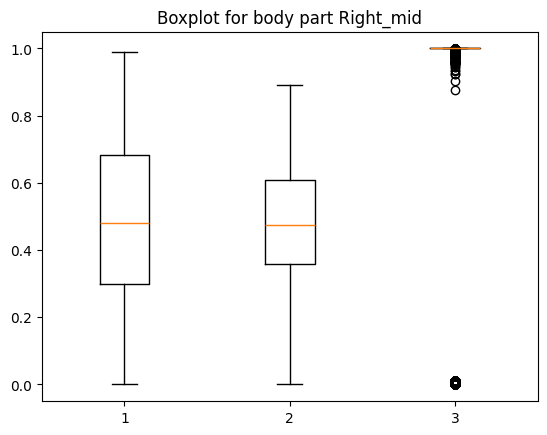

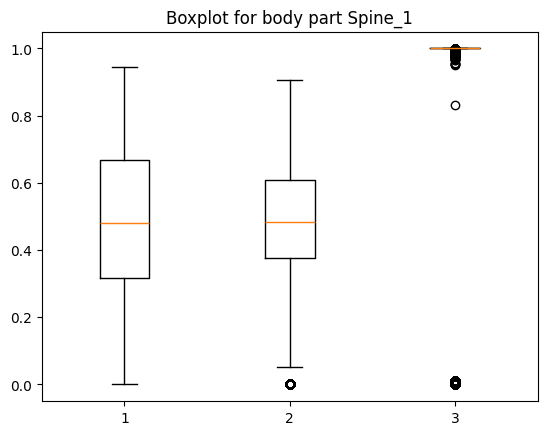

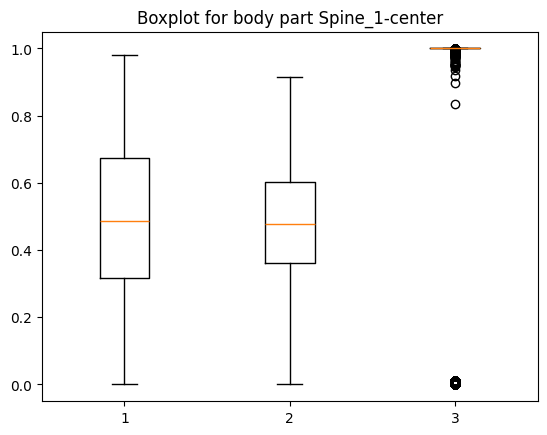

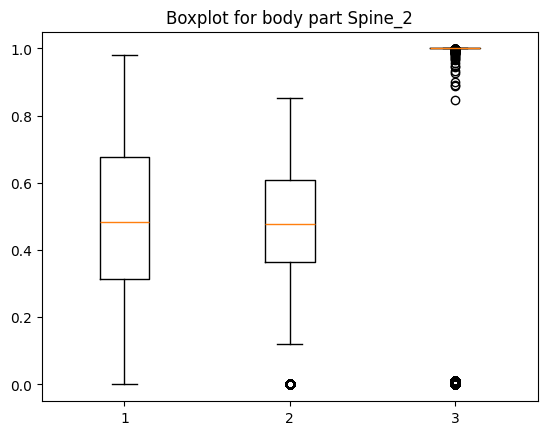

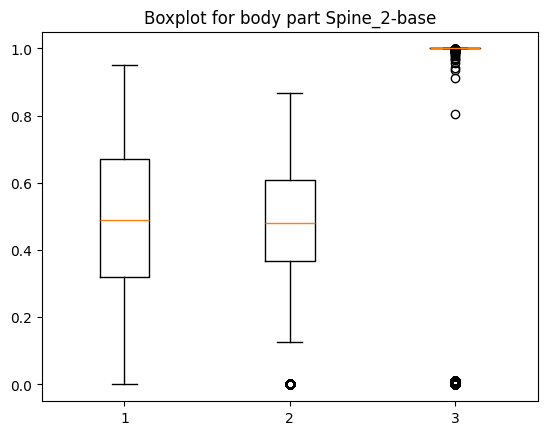

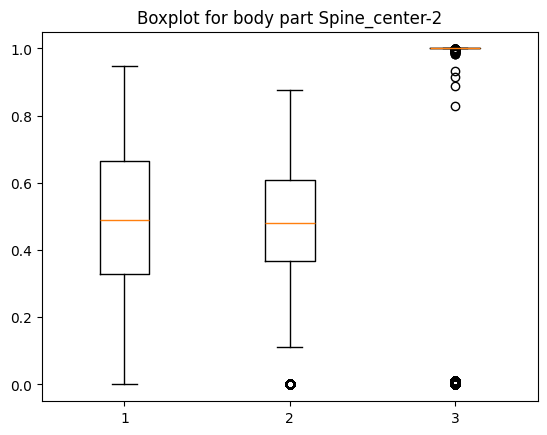

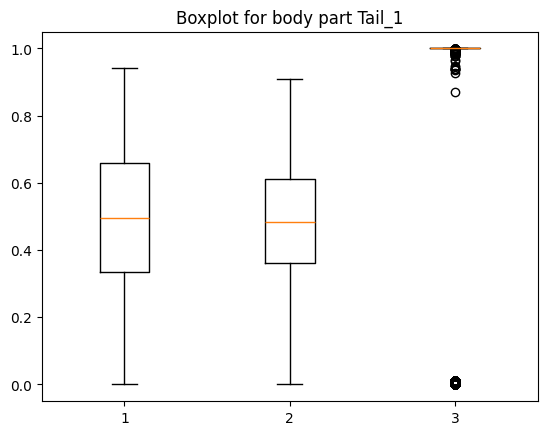

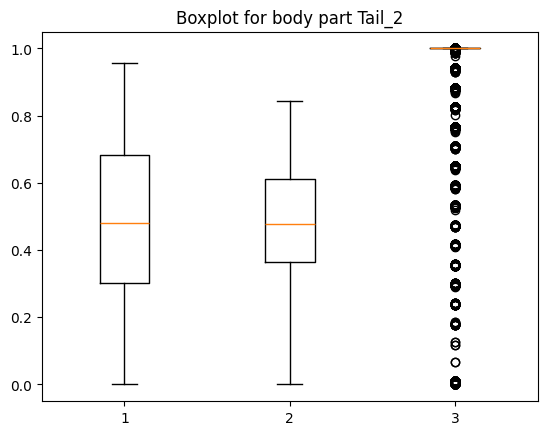

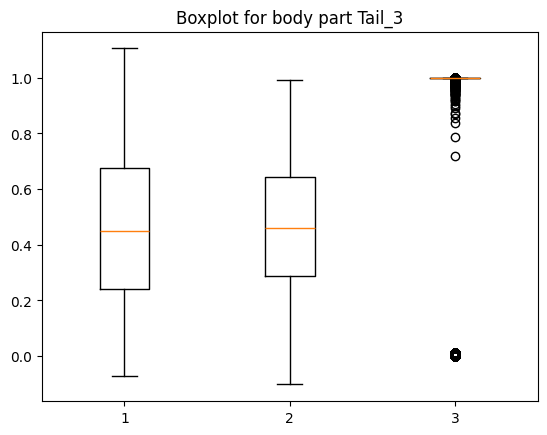

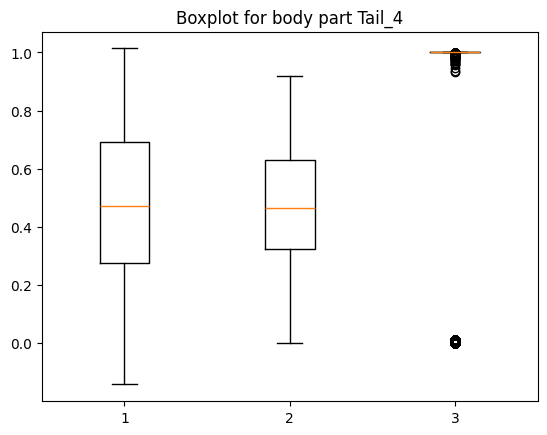

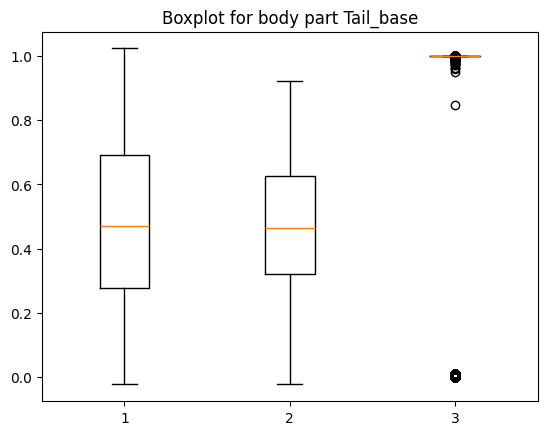

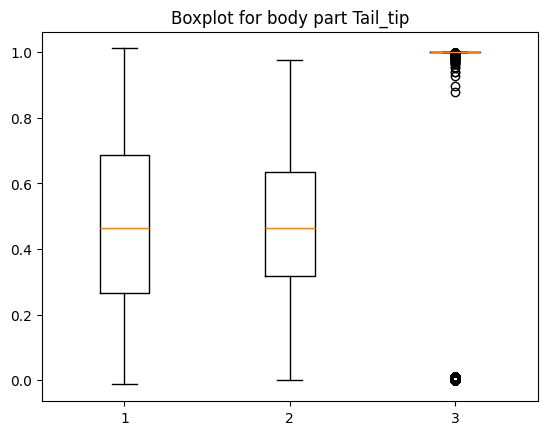

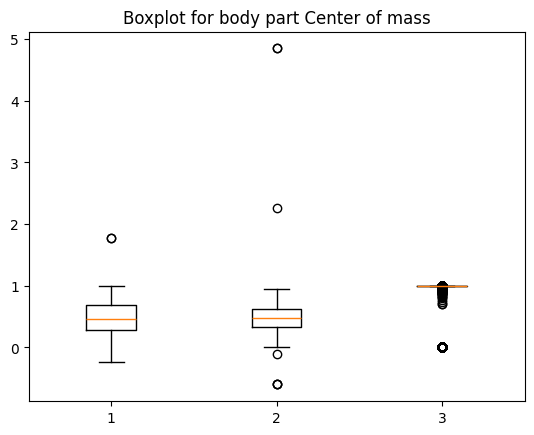

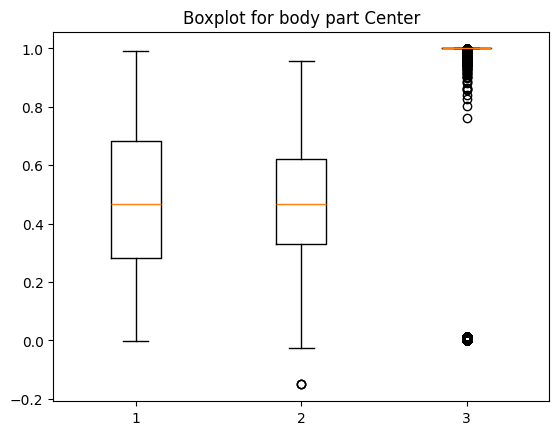

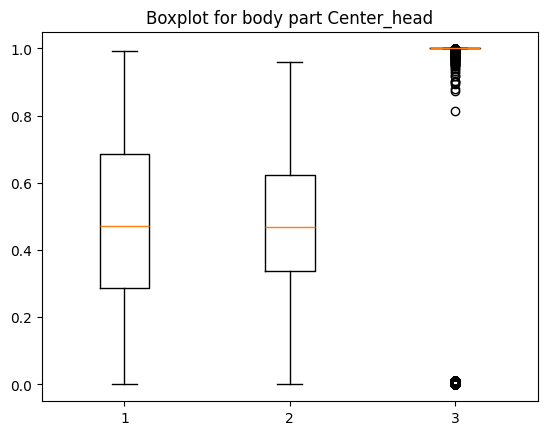

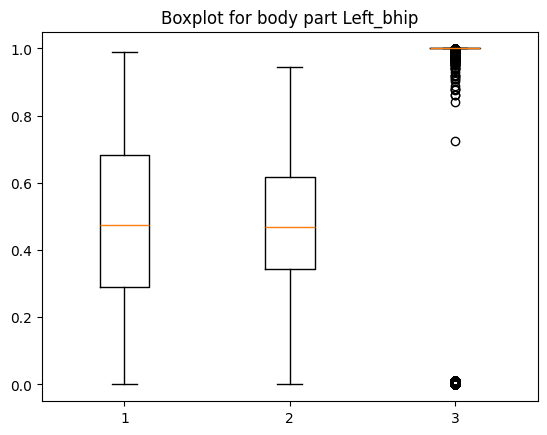

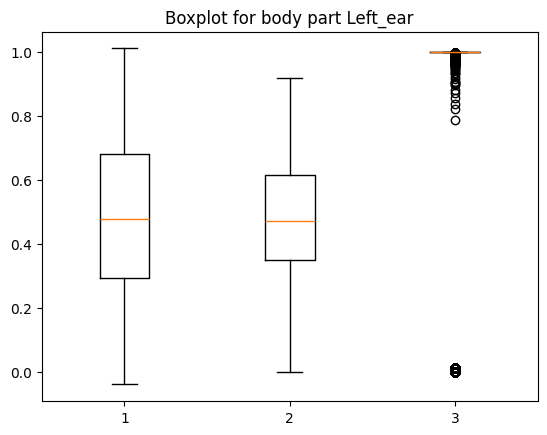

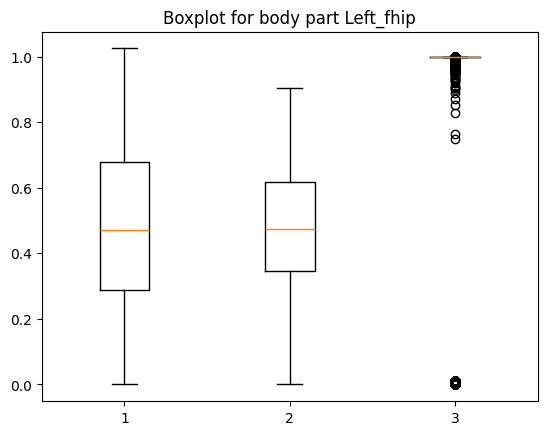

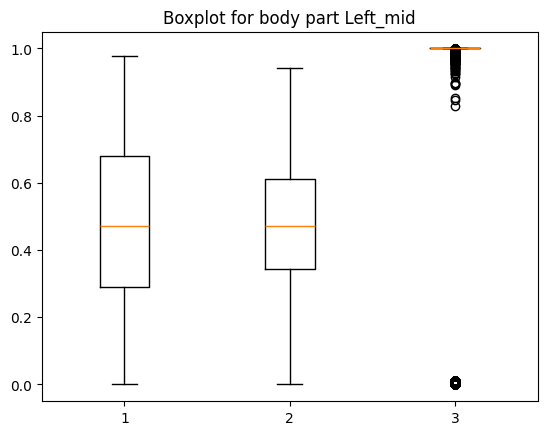

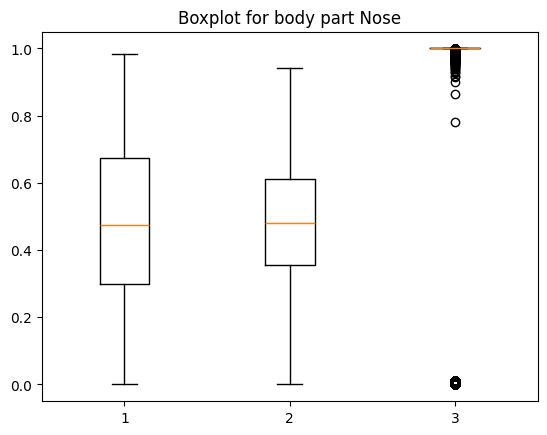

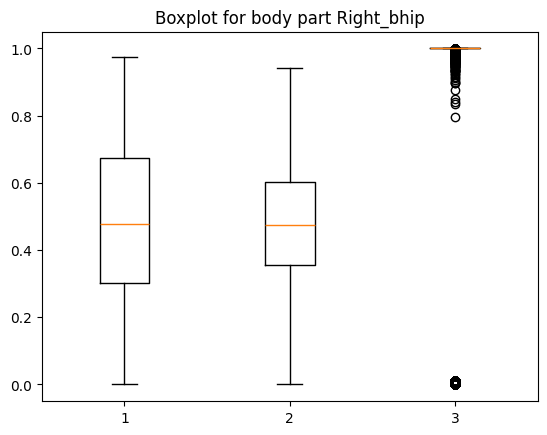

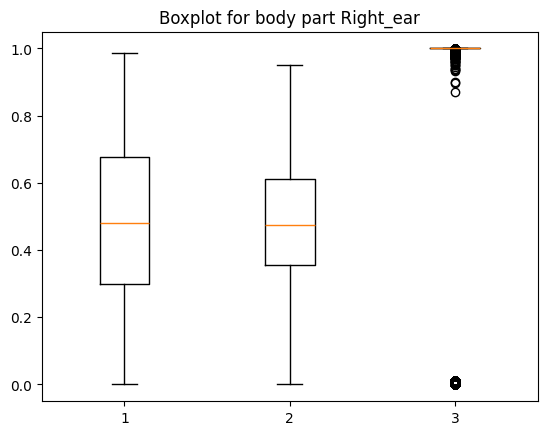

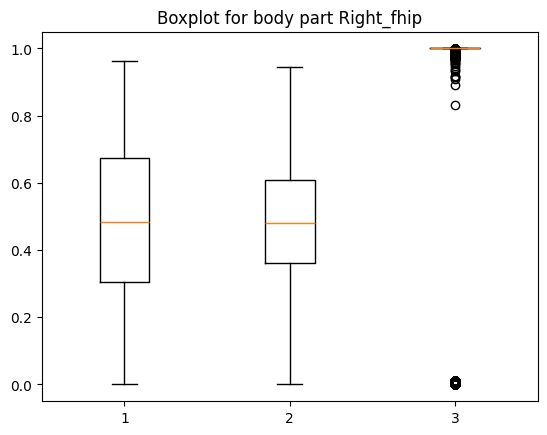

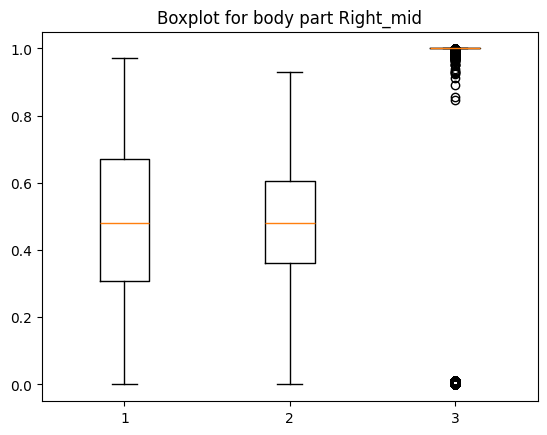

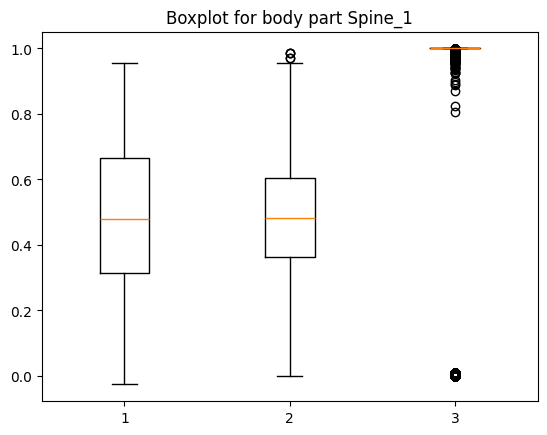

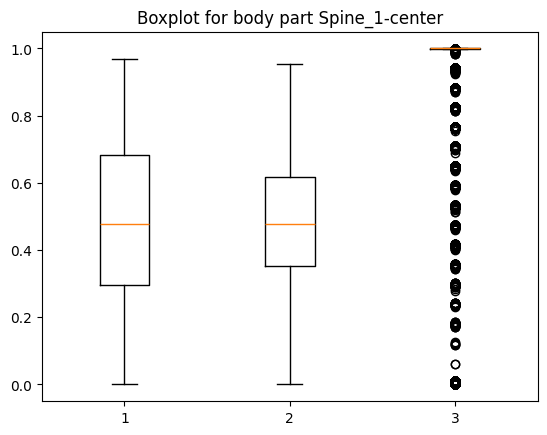

In [39]:
# Check outliers
print("Checking outliers")
# Boxplot
for i in range(X_train.shape[1]//3):
    plt.boxplot(X_train[:, i*3:(i+1)*3])
    plt.title('Boxplot for body part ' + doble_bp[i])
    plt.show()

**Let's check the size of the videos to see the bounderies, the trainning videos were cropped to (640,480)**

In [15]:
# Load a video
path = r'c:\Users\jalvarez\Documents\Data\DLC_analyzedvid\MDX5CV_wo_tail\MDX5CV male\MDXCV_mal_Test_1.mp4'

# Load the video
cap = cv2.VideoCapture(path)
ret, frame = cap.read()
cap.release()

# Get the size of the video
height, width, _ = frame.shape

print("Video size: ", width, height)

# Close everything
cv2.destroyAllWindows()
cv2.waitKey(1)

Video size:  640 480


-1

In [16]:
# Introduce boundaries in features
x_lim = [0, width]
y_lim = [0, height]

# Cast outliers to the limits
print( ' before clipping: ', X_train[:, 0::3].max(), X_train[:, 0::3].min())
print( ' before clipping: ', X_train[:, 1::3].max(), X_train[:, 1::3].min())
X_train[:, 0::3] = np.clip(X_train[:, 0::3], x_lim[0], x_lim[1])
X_train[:, 1::3] = np.clip(X_train[:, 1::3], y_lim[0], y_lim[1])
X_test[:, 0::3] = np.clip(X_test[:, 0::3], x_lim[0], x_lim[1])
X_test[:, 1::3] = np.clip(X_test[:, 1::3], y_lim[0], y_lim[1])
print( ' after clipping: ', X_train[:, 0::3].max(), X_train[:, 0::3].min())
print( ' after clipping: ', X_train[:, 1::3].max(), X_train[:, 1::3].min())


 before clipping:  1.7807305709568984 -0.2359125533835961
 before clipping:  4.845627406990945 -0.6002216859136884
 after clipping:  1.7807305709568984 0.0
 after clipping:  4.845627406990945 0.0


In [17]:
# Scale the data 
X_train[:, 0::3] = (X_train[:, 0::3] - x_lim[0]) / (x_lim[1] - x_lim[0])
X_train[:, 1::3] = (X_train[:, 1::3] - y_lim[0]) / (y_lim[1] - y_lim[0])
X_test[:, 0::3] = (X_test[:, 0::3] - x_lim[0]) / (x_lim[1] - x_lim[0])
X_test[:, 1::3] = (X_test[:, 1::3] - y_lim[0]) / (y_lim[1] - y_lim[0])


# Scale the test

In [40]:
print(X_train.shape)
print(X_test.shape)


(122117, 108)
(30530, 108)


---

### General contact

In [41]:
y_gencont_train = y_train[:, 1]
y_gencont_test = y_test[:, 1]

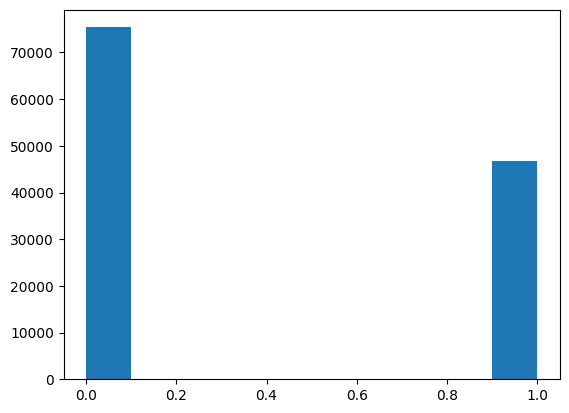

In [42]:
# class balance
plt.hist(y_gencont_train)
plt.show()

In [43]:
# Load baseline model
model = joblib.load(r'C:\Users\jalvarez\Documents\Code\GitHubCOde\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\src\baseline_models\model_gencont.pkl')

# Print the model and number of parameters
print(model)
total_params = 0
for layer in model.coefs_:
    total_params += layer.size
print("Total number of parameters: ", total_params)

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
Total number of parameters:  20900


In [51]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [52]:
model.fit(X_train, y_gencont_train)

Iteration 1, loss = 0.51202051
Iteration 2, loss = 0.42071091
Iteration 3, loss = 0.40689072
Iteration 4, loss = 0.39980539
Iteration 5, loss = 0.39486649


MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [49]:
y_pred = model.predict(X_test)

accuracy_score(y_gencont_test, y_pred)

0.751850638716017

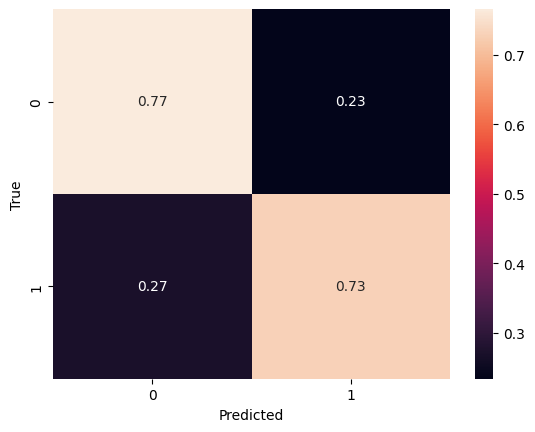

In [50]:
# Confusion matrix


conf_matrix = confusion_matrix(y_gencont_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [89]:
# save model

joblib.dump(model, 'baseline_models/model_gencont.pkl')

['baseline_models/model_gencont.pkl']

---

In [90]:
beh_names[2]

'Sniffing_R'

## Sniff resident

In [91]:
y_sniffR_train = y_train[:, 2]
y_sniffR_test = y_test[:, 2]


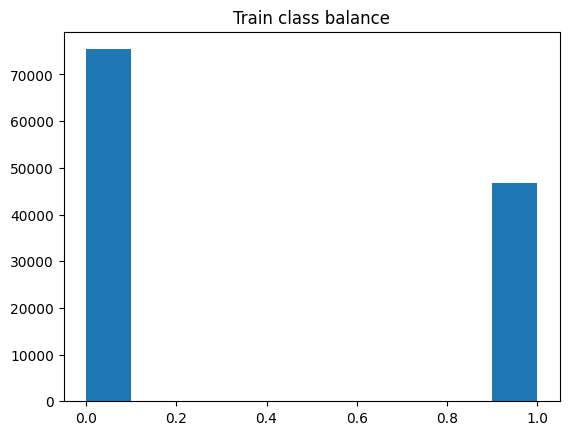

In [92]:
# Class Balance
plt.hist(y_sniffR_train)
plt.title('Train class balance')
plt.show()


In [93]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)


In [94]:
# Train the model
model.fit(X_train, y_sniffR_train)

Iteration 1, loss = 0.50622620
Iteration 2, loss = 0.41864002
Iteration 3, loss = 0.40505928
Iteration 4, loss = 0.39477516
Iteration 5, loss = 0.39215049
Iteration 6, loss = 0.38878575
Iteration 7, loss = 0.38599221
Iteration 8, loss = 0.38231784
Iteration 9, loss = 0.37882614
Iteration 10, loss = 0.37761263
Iteration 11, loss = 0.37560285
Iteration 12, loss = 0.37190500
Iteration 13, loss = 0.36925529
Iteration 14, loss = 0.36812504
Iteration 15, loss = 0.36575231
Iteration 16, loss = 0.36312480
Iteration 17, loss = 0.36184239
Iteration 18, loss = 0.35801742
Iteration 19, loss = 0.35527062
Iteration 20, loss = 0.35355735
Iteration 21, loss = 0.35366972
Iteration 22, loss = 0.35114610
Iteration 23, loss = 0.34696988
Iteration 24, loss = 0.34716186
Iteration 25, loss = 0.34393727
Iteration 26, loss = 0.34128541
Iteration 27, loss = 0.34067669
Iteration 28, loss = 0.33896906
Iteration 29, loss = 0.33669361
Iteration 30, loss = 0.33527035
Iteration 31, loss = 0.33411815
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

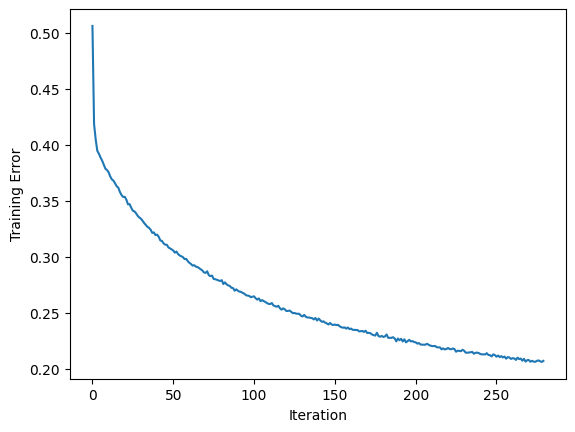

In [95]:
train_errors = model.loss_curve_
plt.plot(train_errors)
plt.xlabel('Iteration')
plt.ylabel('Training Error')
plt.show()


In [96]:
y_pred = model.predict(X_test)

accuracy_score(y_sniffR_test, y_pred)

0.8768096953815919

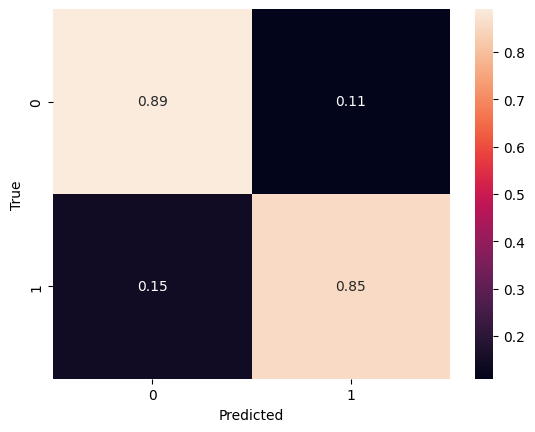

In [97]:
# Confusion matrix

conf_matrix = confusion_matrix(y_sniffR_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [98]:
# Save the model
joblib.dump(model, 'baseline_models/model_sniffR.pkl')

['baseline_models/model_sniffR.pkl']

---

In [99]:
beh_names[3]

'Poursuit_R'

### Poursuite Resident

In [159]:
y_poursuitR_train = y_train[:, 3]
y_poursuitR_test = y_test[:, 3]

In [160]:
# Check Nans in the data

print(np.isnan(y_poursuitR_train).sum())

# Discard the Nans
X_train_pourR = X_train[~np.isnan(y_poursuitR_train)]
y_poursuitR_train = y_poursuitR_train[~np.isnan(y_poursuitR_train)]

X_test_pourR = X_test[~np.isnan(y_poursuitR_test)]
y_poursuitR_test = y_poursuitR_test[~np.isnan(y_poursuitR_test)]




65177


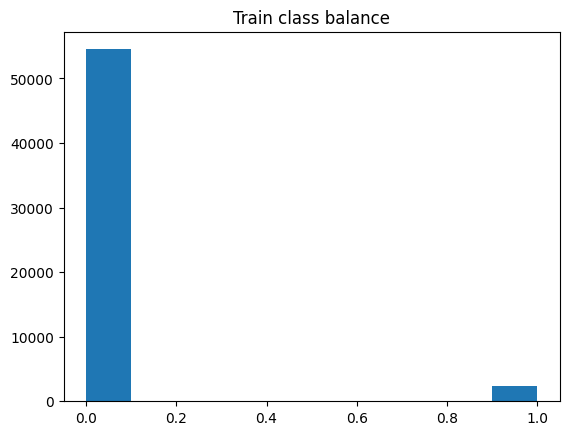

Active:  2432.0
Inactive:  54508.0
 Percentage of active:  0.04271162627327011


In [161]:
# Class Balance
plt.hist(y_poursuitR_train)
plt.title('Train class balance')
plt.show()

print('Active: ', y_poursuitR_train.sum())
print('Inactive: ', (1-y_poursuitR_train).sum())
print(' Percentage of active: ', y_poursuitR_train.sum() / len(y_poursuitR_train))

**I don't have yet sufficient data, but let's try it anyway**

In [162]:
# Downsample the inactive class
idx = np.where(y_poursuitR_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_poursuitR_train == 1), replace=False)
idx = np.concatenate([np.where(y_poursuitR_train == 1)[0], idx])

X_train_pourR = X_train_pourR[idx]
y_poursuitR_train = y_poursuitR_train[idx]


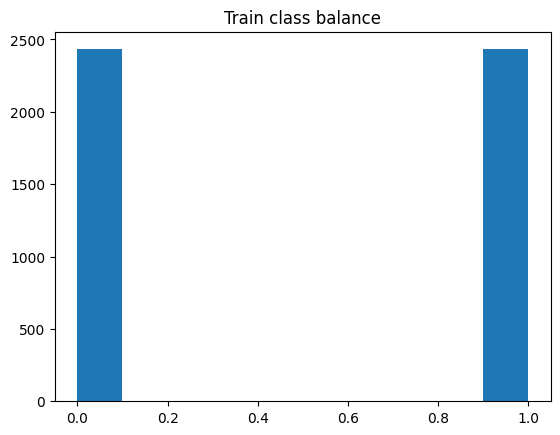

Dimension of the training set:  (4864, 108)


In [163]:
# class balance
plt.hist(y_poursuitR_train)
plt.title('Train class balance')
plt.show()

print('Dimension of the training set: ', X_train_pourR.shape)


In [164]:
# Too many features

In [181]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000, verbose=True)

In [182]:
# Train the model
model.fit(X_train_pourR, y_poursuitR_train)


Iteration 1, loss = 0.68133123
Iteration 2, loss = 0.66097354
Iteration 3, loss = 0.63580253
Iteration 4, loss = 0.61258073
Iteration 5, loss = 0.59593692
Iteration 6, loss = 0.58918666
Iteration 7, loss = 0.56743999
Iteration 8, loss = 0.55075599
Iteration 9, loss = 0.54071468
Iteration 10, loss = 0.52858801
Iteration 11, loss = 0.52003512
Iteration 12, loss = 0.50245067
Iteration 13, loss = 0.49691729
Iteration 14, loss = 0.47566278
Iteration 15, loss = 0.47147198
Iteration 16, loss = 0.46035153
Iteration 17, loss = 0.45373354
Iteration 18, loss = 0.44460608
Iteration 19, loss = 0.43554740
Iteration 20, loss = 0.43967378
Iteration 21, loss = 0.43731664
Iteration 22, loss = 0.44453605
Iteration 23, loss = 0.43761011
Iteration 24, loss = 0.41659585
Iteration 25, loss = 0.40371744
Iteration 26, loss = 0.40151781
Iteration 27, loss = 0.40437426
Iteration 28, loss = 0.40053930
Iteration 29, loss = 0.40922020
Iteration 30, loss = 0.41105043
Iteration 31, loss = 0.39512397
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [183]:
# Test the model
y_pred = model.predict(X_test_pourR)

accuracy_score(y_poursuitR_test, y_pred)


0.836212412028151

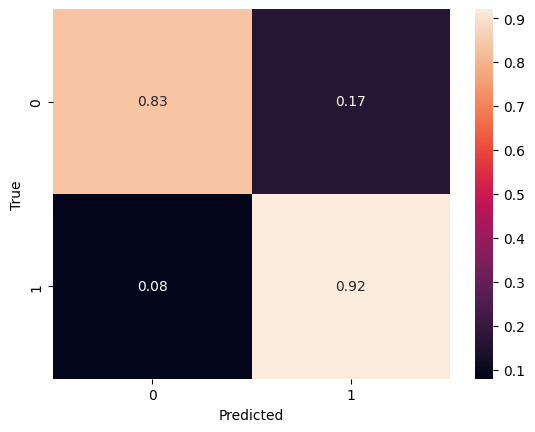

In [184]:
# Confusion matrix
conf_matrix = confusion_matrix(y_poursuitR_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [185]:
# Save the model
joblib.dump(model, 'baseline_models/model_poursuitR.pkl')

['baseline_models/model_poursuitR.pkl']

---

In [186]:
beh_names[4]

'Dominance_R'

## Dominance Resident

In [187]:
y_domR_train = y_train[:,4]
y_domR_test = y_test[:,4]

print(' Nans : ', np.isnan(y_domR_train).sum())

# Get rid of Nan's
X_train_dom_R = X_train[~np.isnan(y_domR_train)]
y_train_dom_R = y_domR_train[~np.isnan(y_domR_train)]

X_test_dom_R = X_test[~np.isnan(y_domR_test)]
y_test_dom_R = y_domR_test[~np.isnan(y_domR_test)] 



 Nans :  65177


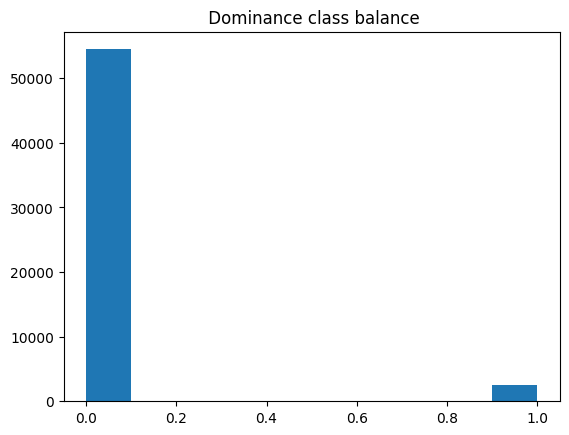

 Dominance events: 2454.0
 Inactive events  54486.0
 Percentqge: 0.04309799789251844


In [188]:
# class balance
plt.hist(y_train_dom_R)
plt.title(" Dominance class balance")
plt.show()

print(' Dominance events:', y_train_dom_R.sum())
print(' Inactive events ', (1 - y_train_dom_R).sum())
print(' Percentqge:',  y_train_dom_R.sum()/len(y_train_dom_R))


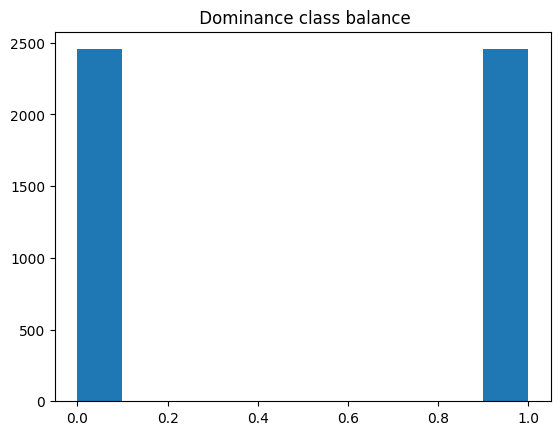

Dimension of the training set:  (4908, 108)


In [189]:
# Downsample the inactive class
idx = np.where(y_train_dom_R == 0)[0]
idx = np.random.choice(idx, np.sum(y_train_dom_R == 1), replace=False)
idx = np.concatenate([np.where(y_train_dom_R == 1)[0], idx])

X_train_dom_R = X_train_dom_R[idx]
y_train_dom_R = y_train_dom_R[idx]

# class balance
plt.hist(y_train_dom_R)
plt.title(" Dominance class balance")
plt.show()

print('Dimension of the training set: ', X_train_dom_R.shape)

In [190]:
# fit the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

model.fit(X_train_dom_R, y_train_dom_R)


Iteration 1, loss = 0.60476185
Iteration 2, loss = 0.54913898
Iteration 3, loss = 0.53034485
Iteration 4, loss = 0.52027449
Iteration 5, loss = 0.50650320
Iteration 6, loss = 0.51209809
Iteration 7, loss = 0.49608844
Iteration 8, loss = 0.49617532
Iteration 9, loss = 0.48713263
Iteration 10, loss = 0.48565399
Iteration 11, loss = 0.47525397
Iteration 12, loss = 0.46757339
Iteration 13, loss = 0.46502256
Iteration 14, loss = 0.45707455
Iteration 15, loss = 0.44739224
Iteration 16, loss = 0.44423331
Iteration 17, loss = 0.44019652
Iteration 18, loss = 0.44495267
Iteration 19, loss = 0.43518923
Iteration 20, loss = 0.42988287
Iteration 21, loss = 0.42158845
Iteration 22, loss = 0.41691077
Iteration 23, loss = 0.43498104
Iteration 24, loss = 0.41972042
Iteration 25, loss = 0.41135635
Iteration 26, loss = 0.41502343
Iteration 27, loss = 0.41321998
Iteration 28, loss = 0.40295023
Iteration 29, loss = 0.39759330
Iteration 30, loss = 0.39588333
Iteration 31, loss = 0.39171166
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [191]:
# Test the model
y_pred = model.predict(X_test_dom_R)

accuracy_score(y_test_dom_R, y_pred)


0.8283926921163005

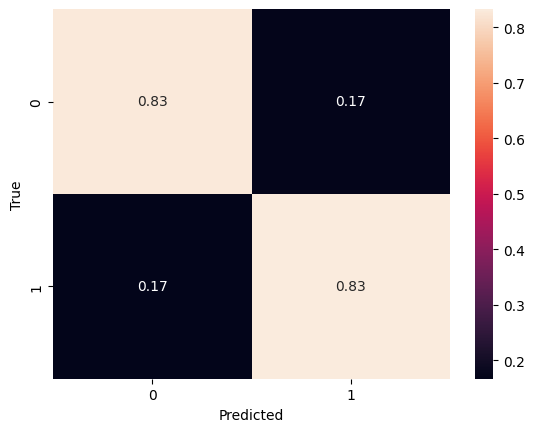

In [192]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_dom_R, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [193]:
# Save the model
joblib.dump(model, 'baseline_models/model_domR.pkl')

['baseline_models/model_domR.pkl']

---

In [194]:
beh_names[5]

'Rearing_R'

# Rearing R

In [46]:
y_rearingR_train = y_train[:, 5]
y_rearingR_test = y_test[:, 5]

In [47]:
# Check Nans in the data
np.isnan(y_rearingR_train).sum()

0

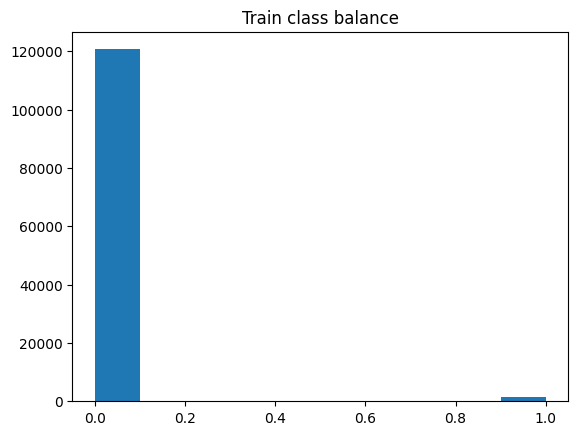

Active:  1441
Inactive:  120676
Percentage:  0.011800158864040223


In [48]:
# Class Balance
plt.hist(y_rearingR_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_rearingR_train == 1))
print('Inactive: ', np.sum(y_rearingR_train == 0))
print('Percentage: ', np.sum(y_rearingR_train == 1) / len(y_rearingR_train))



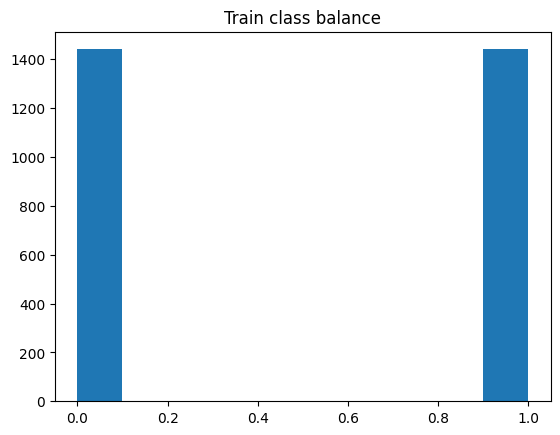

 Train dataset size:  (2882, 108)


In [49]:
# Downsample the inactive class
idx = np.where(y_rearingR_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_rearingR_train == 1), replace=False)
idx = np.concatenate([np.where(y_rearingR_train == 1)[0], idx])
idx = np.random.permutation(idx)

X_rearingR_train = X_train[idx]
y_rearingR_train = y_rearingR_train[idx]

# class balance
plt.hist(y_rearingR_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_rearingR_train.shape)


In [50]:
# Create the model

model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

# Train the model
model.fit(X_rearingR_train, y_rearingR_train)

Iteration 1, loss = 0.70475281
Iteration 2, loss = 0.68059146
Iteration 3, loss = 0.67021289
Iteration 4, loss = 0.65568707
Iteration 5, loss = 0.64467486
Iteration 6, loss = 0.63244228
Iteration 7, loss = 0.62148888
Iteration 8, loss = 0.61847298
Iteration 9, loss = 0.61324268
Iteration 10, loss = 0.60830043
Iteration 11, loss = 0.60162919
Iteration 12, loss = 0.59874242
Iteration 13, loss = 0.59365031
Iteration 14, loss = 0.59300872
Iteration 15, loss = 0.59366389
Iteration 16, loss = 0.58947622
Iteration 17, loss = 0.58291012
Iteration 18, loss = 0.57810129
Iteration 19, loss = 0.57974423
Iteration 20, loss = 0.57647937
Iteration 21, loss = 0.57599039
Iteration 22, loss = 0.57269587
Iteration 23, loss = 0.56572074
Iteration 24, loss = 0.56384907
Iteration 25, loss = 0.56204688
Iteration 26, loss = 0.56606471
Iteration 27, loss = 0.56227443
Iteration 28, loss = 0.55649574
Iteration 29, loss = 0.56141817
Iteration 30, loss = 0.55569180
Iteration 31, loss = 0.55384853
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [51]:
# Test the model
y_pred = model.predict(X_test)

accuracy_score(y_rearingR_test, y_pred)


0.7333114968883065

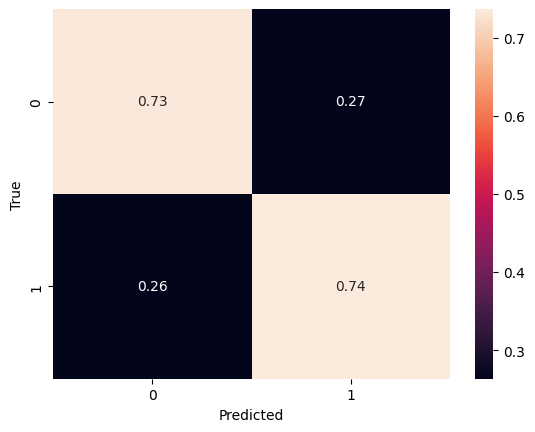

In [52]:
# Confusion matrix
conf_matrix = confusion_matrix(y_rearingR_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [215]:
# Get variance of the a accuracy
acc = []
for i in range(10):
    y_rearingR_train = y_train[:, 5]
    y_rearingR_test = y_test[:, 5]

    # Downsample the inactive class
    idx = np.where(y_rearingR_train == 0)[0]
    idx = np.random.choice(idx, np.sum(y_rearingR_train == 1), replace=False)
    idx = np.concatenate([np.where(y_rearingR_train == 1)[0], idx])
    idx = np.random.permutation(idx)

    X_rearingR_train = X_train[idx]
    y_rearingR_train = y_rearingR_train[idx]

    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=False, random_state=42) 

    # Train the model
    model.fit(X_rearingR_train, y_rearingR_train)

    # Test the model
    y_pred = model.predict(X_test)

    acc.append(accuracy_score(y_rearingR_test, y_pred))

print('Mean accuracy: ', np.mean(acc))
print('Variance: ', np.var(acc))


Mean accuracy:  0.7320602685882739
Variance:  0.002682676750483782


In [233]:
# save the model
joblib.dump(model, 'baseline_models/model_rearingR.pkl')

['baseline_models/model_rearingR.pkl']

---

In [234]:
beh_names[6]

'Grooming_R'

## Grooming Resident

Nan's  0


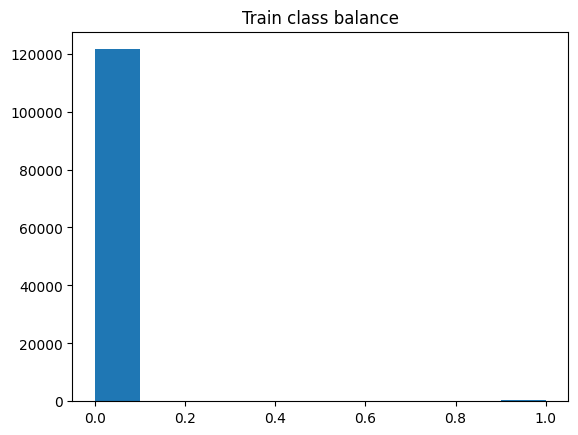

Active:  594
Inactive:  121523
Percentage:  0.004864187623344825


In [36]:
y_groomR_train = y_train[:, 6]
y_groomR_test = y_test[:, 6]

# Check Nans in the data
print("Nan's ", np.isnan(y_groomR_train).sum())

# Class Balance
plt.hist(y_groomR_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_groomR_train == 1))
print('Inactive: ', np.sum(y_groomR_train == 0))
print('Percentage: ', np.sum(y_groomR_train == 1) / len(y_groomR_train))



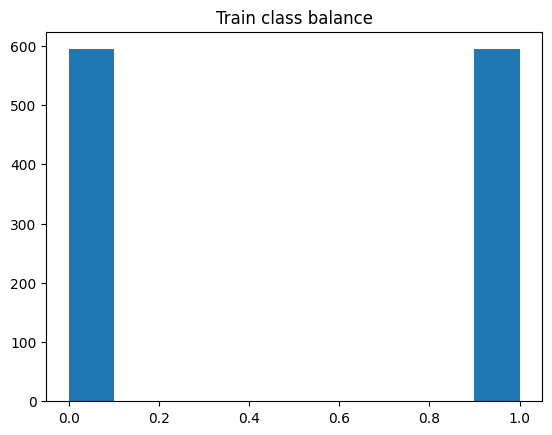

 Train dataset size:  (1188, 108)


In [37]:
# Downsample the inactive class
idx = np.where(y_groomR_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_groomR_train == 1), replace=False)
idx = np.concatenate([np.where(y_groomR_train == 1)[0], idx])
idx = np.random.permutation(idx)

X_groomR_train = X_train[idx]
y_groomR_train = y_groomR_train[idx]

# class balance
plt.hist(y_groomR_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_groomR_train.shape)


In [38]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100), max_iter=1000, verbose=True)

# Train the model
model.fit(X_groomR_train, y_groomR_train)


Iteration 1, loss = 0.70813832
Iteration 2, loss = 0.68065584
Iteration 3, loss = 0.66808194
Iteration 4, loss = 0.66409479
Iteration 5, loss = 0.65660500
Iteration 6, loss = 0.65512753
Iteration 7, loss = 0.65300559
Iteration 8, loss = 0.65007021
Iteration 9, loss = 0.64635150
Iteration 10, loss = 0.63946764
Iteration 11, loss = 0.63589848
Iteration 12, loss = 0.63495403
Iteration 13, loss = 0.63320109
Iteration 14, loss = 0.63005826
Iteration 15, loss = 0.62761338
Iteration 16, loss = 0.62611928
Iteration 17, loss = 0.62243959
Iteration 18, loss = 0.61813672
Iteration 19, loss = 0.62078270
Iteration 20, loss = 0.61412724
Iteration 21, loss = 0.60901832
Iteration 22, loss = 0.60731204
Iteration 23, loss = 0.60251939
Iteration 24, loss = 0.60107363
Iteration 25, loss = 0.60077409
Iteration 26, loss = 0.60187150
Iteration 27, loss = 0.59731100
Iteration 28, loss = 0.59618772
Iteration 29, loss = 0.59123146
Iteration 30, loss = 0.59020609
Iteration 31, loss = 0.58308705
Iteration 32, los

MLPClassifier(hidden_layer_sizes=100, max_iter=1000, verbose=True)

In [238]:
# Test the model
y_pred = model.predict(X_test)

accuracy_score(y_groomR_test, y_pred)


0.8220438912545037

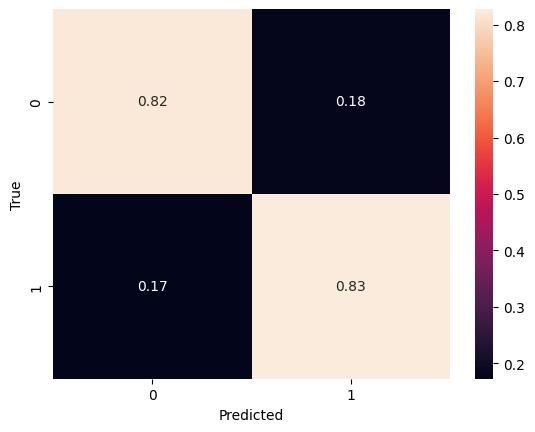

In [239]:
# Confusion matrix
conf_matrix = confusion_matrix(y_groomR_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


THis makes no sense

In [240]:
# save the model
joblib.dump(model, 'baseline_models/model_groomR.pkl')


['baseline_models/model_groomR.pkl']

In [241]:
# run several times to get the variance of the accuracy
acc = []

for i in range(10):
    y_groomR_train = y_train[:, 6]
    y_groomR_test = y_test[:, 6]

    # Downsample the inactive class
    idx = np.where(y_groomR_train == 0)[0]
    idx = np.random.choice(idx, np.sum(y_groomR_train == 1), replace=False)
    idx = np.concatenate([np.where(y_groomR_train == 1)[0], idx])
    idx = np.random.permutation(idx)

    X_groomR_train = X_train[idx]
    y_groomR_train = y_groomR_train[idx]

    model = MLPClassifier(hidden_layer_sizes=(100), max_iter=1000, verbose=False, random_state=42) 

    # Train the model
    model.fit(X_groomR_train, y_groomR_train)

    # Test the model
    y_pred = model.predict(X_test)

    acc.append(accuracy_score(y_groomR_test, y_pred))

print('Mean accuracy: ', np.mean(acc))
print('Variance: ', np.var(acc))

Mean accuracy:  0.8041500163773337
Variance:  0.0061897022136168664


---

In [382]:
beh_names[7]

'Sniffing_V'

## Sinff Visiteur

In [383]:
y_sniffV_train = y_train[:, 7]
y_sniffV_test = y_test[:, 7]


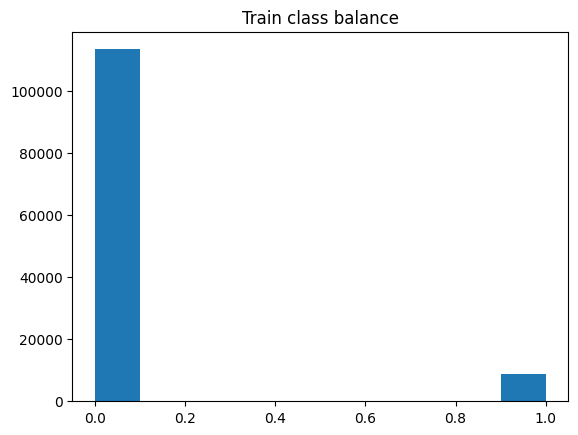

Active:  8799
Inactive:  113318
Percentage:  0.072053849996315


In [384]:
# Class Balance
plt.hist(y_sniffV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_sniffV_train == 1))
print('Inactive: ', np.sum(y_sniffV_train == 0))
print('Percentage: ', np.sum(y_sniffV_train == 1) / len(y_sniffV_train))



In [385]:
# Downsample the Inactive class
np.random.seed(42)
idx = np.where(y_sniffV_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_sniffV_train == 1), replace=False)
idx = np.concatenate([idx, np.where(y_sniffV_train == 1)[0]])
idx = np.random.permutation(idx)
X_train_sniff_V = X_train[idx]
y_sniffV_train = y_sniffV_train[idx]

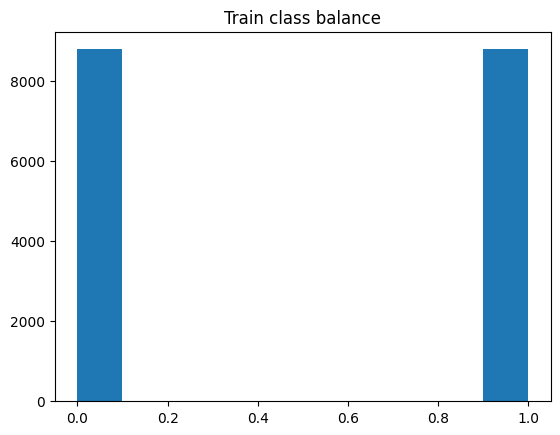

In [386]:
# class balance
plt.hist(y_sniffV_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_train_sniff_V.shape)


In [387]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)


In [388]:
# Train the model
model.fit(X_train_sniff_V, y_sniffV_train)


Iteration 1, loss = 0.64789867
Iteration 2, loss = 0.56687938
Iteration 3, loss = 0.50913318
Iteration 4, loss = 0.46552506
Iteration 5, loss = 0.43930679
Iteration 6, loss = 0.42713193
Iteration 7, loss = 0.41812745
Iteration 8, loss = 0.40956297
Iteration 9, loss = 0.40182529
Iteration 10, loss = 0.40054321
Iteration 11, loss = 0.39821207
Iteration 12, loss = 0.39294846
Iteration 13, loss = 0.38581481
Iteration 14, loss = 0.38194715
Iteration 15, loss = 0.38258621
Iteration 16, loss = 0.38729193
Iteration 17, loss = 0.37663777
Iteration 18, loss = 0.37608958
Iteration 19, loss = 0.38030478
Iteration 20, loss = 0.37118825
Iteration 21, loss = 0.37438138
Iteration 22, loss = 0.36990951
Iteration 23, loss = 0.36512836
Iteration 24, loss = 0.37009905
Iteration 25, loss = 0.36321413
Iteration 26, loss = 0.35770959
Iteration 27, loss = 0.36243292
Iteration 28, loss = 0.35852321
Iteration 29, loss = 0.35821103
Iteration 30, loss = 0.35610503
Iteration 31, loss = 0.35665148
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [389]:
y_pred = model.predict(X_test)

accuracy_score(y_sniffV_test, y_pred)

0.8407140517523747

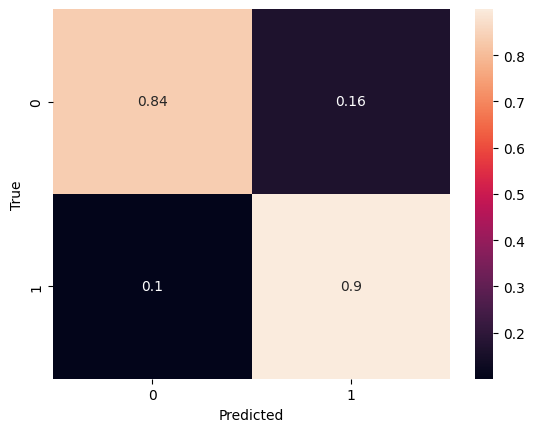

In [390]:
# Confusion matrix
conf_matrix = confusion_matrix(y_sniffV_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [391]:
# Save the model
joblib.dump(model, 'baseline_models/model_sniffV.pkl')

['baseline_models/model_sniffV.pkl']

---

In [392]:
beh_names[8]

'Poursuit_V'

## Poursuite Visiteur

In [393]:
y_poursuitV_train = y_train[:, 8]
y_poursuitV_test = y_test[:, 8]


0


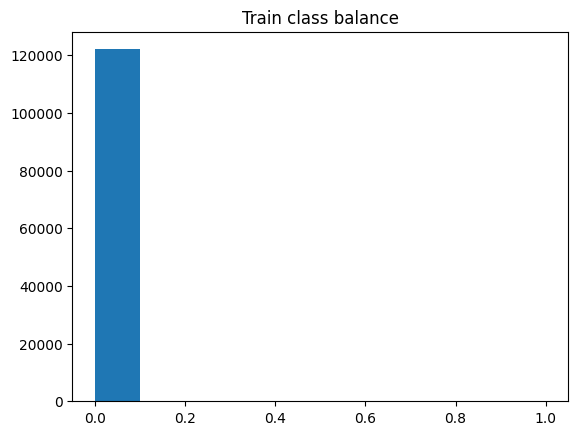

Active:  50
Inactive:  122067
Percentage:  0.0004094434026384533


In [394]:
# check Nans in the data
print(np.isnan(y_poursuitV_train).sum())

# Class Balance
plt.hist(y_poursuitV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_poursuitV_train == 1))
print('Inactive: ', np.sum(y_poursuitV_train == 0))
print('Percentage: ', np.sum(y_poursuitV_train == 1) / len(y_poursuitV_train))



---

In [395]:
beh_names[9]

'Dominance_V'

## Dominance Visiteur

0


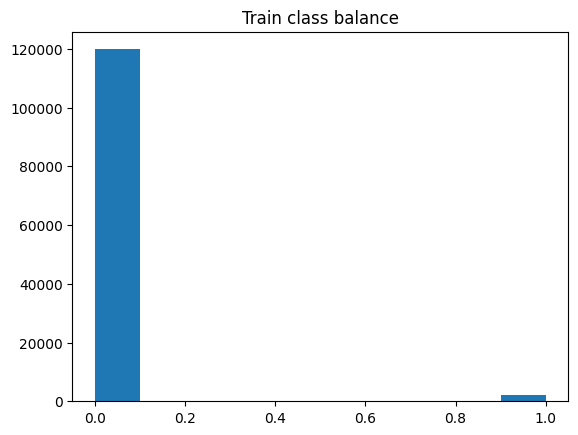

Active:  2269
Inactive:  119848
Percentage:  0.01858054161173301


In [396]:
y_domV_train = y_train[:, 9]
y_domV_test = y_test[:, 9]

# Check Nans in the data
print(np.isnan(y_domV_train).sum())

# Class Balance
plt.hist(y_domV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_domV_train == 1))
print('Inactive: ', np.sum(y_domV_train == 0))
print('Percentage: ', np.sum(y_domV_train == 1) / len(y_domV_train))


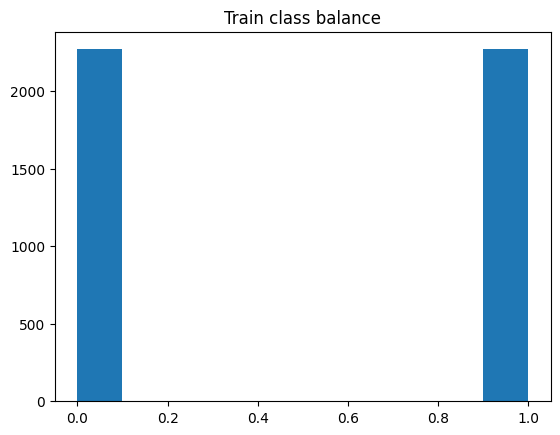

 Train dataset size:  (4538, 108)


In [397]:
# Downsample the Inactive class
np.random.seed(42)
idx = np.where(y_domV_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_domV_train == 1), replace=False)
idx = np.concatenate([idx, np.where(y_domV_train == 1)[0]])
idx = np.random.permutation(idx)

X_train_dom_V = X_train[idx]
y_domV_train = y_domV_train[idx]

# class balance
plt.hist(y_domV_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_train_dom_V.shape)


In [398]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100), max_iter=1000, verbose=True)

# Train the model
model.fit(X_train_dom_V, y_domV_train)



Iteration 1, loss = 0.66307297
Iteration 2, loss = 0.63698538
Iteration 3, loss = 0.62550067
Iteration 4, loss = 0.61380114
Iteration 5, loss = 0.60439996
Iteration 6, loss = 0.60166150
Iteration 7, loss = 0.60012970
Iteration 8, loss = 0.58493456
Iteration 9, loss = 0.57697678
Iteration 10, loss = 0.56724133
Iteration 11, loss = 0.56289911
Iteration 12, loss = 0.55555724
Iteration 13, loss = 0.54748991
Iteration 14, loss = 0.54135891
Iteration 15, loss = 0.53411973
Iteration 16, loss = 0.52800909
Iteration 17, loss = 0.52043033
Iteration 18, loss = 0.51270632
Iteration 19, loss = 0.50505003
Iteration 20, loss = 0.50054549
Iteration 21, loss = 0.50171192
Iteration 22, loss = 0.50119345
Iteration 23, loss = 0.49779103
Iteration 24, loss = 0.48585560
Iteration 25, loss = 0.48058164
Iteration 26, loss = 0.48219672
Iteration 27, loss = 0.47836855
Iteration 28, loss = 0.46620608
Iteration 29, loss = 0.46161334
Iteration 30, loss = 0.45722888
Iteration 31, loss = 0.45534634
Iteration 32, los

MLPClassifier(hidden_layer_sizes=100, max_iter=1000, verbose=True)

In [399]:
# Test the model
y_pred = model.predict(X_test)

accuracy_score(y_domV_test, y_pred)

0.8236161152964298

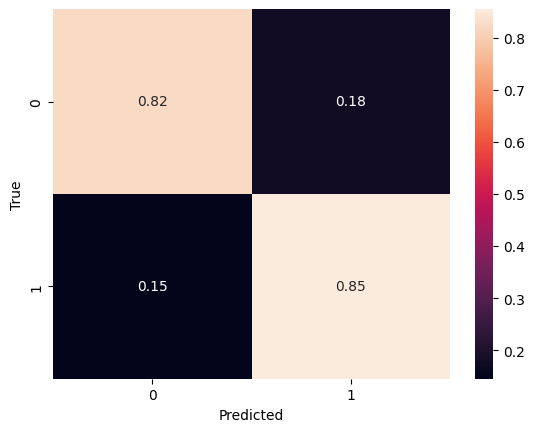

In [400]:
# Confusion matrix
conf_matrix = confusion_matrix(y_domV_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [401]:
beh_names[10]

'Rearing_V'

---

In [149]:
beh_names[11]

'Grooming_V'

## Grooming Visiteur

In [150]:
y_groomV_train = y_train[:, 11]
y_groomV_test = y_test[:, 11]

In [151]:
print(len(y_groomV_train))

122117


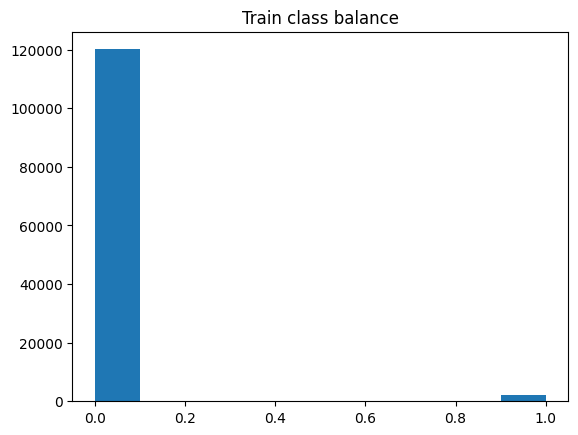

Active:  2015
Inactive:  120102
Percentage:  0.01650056912632967


In [152]:
# Class Balance
plt.hist(y_groomV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_groomV_train == 1))
print('Inactive: ', np.sum(y_groomV_train == 0))
print('Percentage: ', np.sum(y_groomV_train == 1) / len(y_groomV_train))


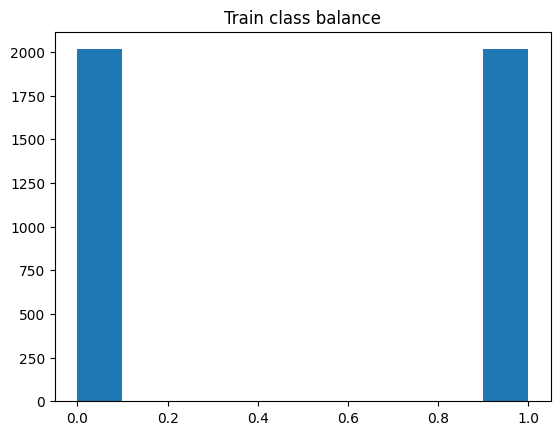

(4030, 108)


In [153]:
# Downsample the Inactive class
np.random.seed(42)
idx = np.where(y_groomV_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_groomV_train == 1), replace=False)
idx = np.concatenate([idx, np.where(y_groomV_train == 1)[0]])
idx = np.random.permutation(idx)
X_train_groom_V = X_train[idx]
y_groomV_train = y_groomV_train[idx]

# class balance
plt.hist(y_groomV_train)
plt.title('Train class balance')
plt.show()

print(X_train_groom_V.shape)

In [154]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True, tol = 1e-5)


In [155]:
# Train the model
model.fit(X_train_groom_V, y_groomV_train)

Iteration 1, loss = 0.68440102
Iteration 2, loss = 0.64324331
Iteration 3, loss = 0.61958835
Iteration 4, loss = 0.60707684
Iteration 5, loss = 0.60132217
Iteration 6, loss = 0.57625439
Iteration 7, loss = 0.55674354
Iteration 8, loss = 0.54236985
Iteration 9, loss = 0.52680195
Iteration 10, loss = 0.51444510
Iteration 11, loss = 0.50242655
Iteration 12, loss = 0.49053301
Iteration 13, loss = 0.49206163
Iteration 14, loss = 0.48210159
Iteration 15, loss = 0.46971539
Iteration 16, loss = 0.46813472
Iteration 17, loss = 0.45628605
Iteration 18, loss = 0.45651074
Iteration 19, loss = 0.44830052
Iteration 20, loss = 0.44998572
Iteration 21, loss = 0.42794391
Iteration 22, loss = 0.42499874
Iteration 23, loss = 0.42787740
Iteration 24, loss = 0.42013941
Iteration 25, loss = 0.43498817
Iteration 26, loss = 0.41121910
Iteration 27, loss = 0.40772790
Iteration 28, loss = 0.43178337
Iteration 29, loss = 0.40091596
Iteration 30, loss = 0.39979853
Iteration 31, loss = 0.38634732
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, tol=1e-05,
              verbose=True)

In [156]:
y_pred = model.predict(X_test)
accuracy_score(y_groomV_test, y_pred)

0.8321323288568621

In [158]:
print(' Predicted: ', y_pred.sum())
print(' Non predicted: ', len(y_pred) - y_pred.sum())

 Predicted:  5568.0
 Non predicted:  24962.0


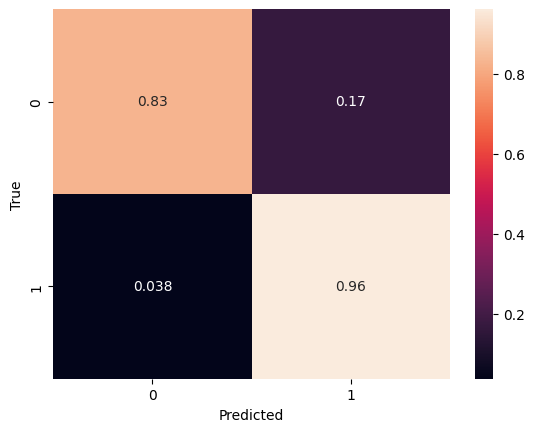

In [157]:
# Confusion matrix
conf_matrix = confusion_matrix(y_groomV_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [412]:
beh_names[12]

IndexError: index 12 is out of bounds for axis 0 with size 12

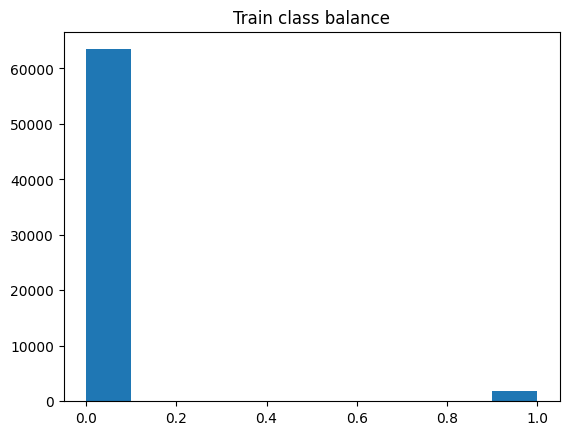

In [152]:
y_pourV_train = y_train[:, 7]
y_pourV_test = y_test[:, 10]

# Class Balance
plt.hist(y_pourV_train)
plt.title('Train class balance')
plt.show()


---

---

---

---


---

---

---

---

---

---

---

---

---

# This is only data cleannning, renaming, grouping, etc

#### Extra checks

In [42]:
import os

In [44]:
df = pd.read_csv(r'c:\Users\jalvarez\Documents\Data\DataLoader_DMD_null_male\DMD_mal_Test_1.csv')
original_column = df.columns

In [45]:
# Check that the columns are ordered in the .csv files contained in the path
files_path = r'c:\Users\jalvarez\Documents\Data\DataLoader_DMD_null_male' 

for file in os.listdir(files_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(files_path, file))
        if not np.array_equal(original_column, df.columns):
            print(file)
        

### Adding all the missing behaviors

In [36]:
csv_file = r'c:\Users\jalvarez\Documents\Data\Behaviour\MDX5CV\male female\Test_1.csv'

df = pd.read_csv(csv_file)
df.sum(axis=0)

Frame                               3446625.0
contacts generaux (R + V) active       1966.0
sniff total resident active            1993.0
redressement R active                    11.0
grooming R active                         0.0
poursuite R active                      200.0
dominance R active                      272.0
grooming V active                         5.0
sniff total visiteur active             352.0
redressement V active                    37.0
poursuite V active                        0.0
dominance V active                        2.0
dtype: float64

In [47]:
behaviours = ['Frames', 'General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V', 'Grooming_V']
original_column = ['Frame', 'contacts generaux (R + V) active', 'sniff total resident active', 'poursuite R active', 'dominance R active', 'redressement R active', 'grooming R active',
                    'sniff total visiteur active', 'poursuite V active', 'dominance V active', 'redressement V active', 'grooming V active']

In [48]:
dict_columns = dict(zip(original_column, behaviours))

In [49]:
dict_columns

{'Frame': 'Frames',
 'contacts generaux (R + V) active': 'General_Contacts',
 'sniff total resident active': 'Sniffing_R',
 'poursuite R active': 'Poursuit_R',
 'dominance R active': 'Dominance_R',
 'redressement R active': 'Rearing_R',
 'grooming R active': 'Grooming_R',
 'sniff total visiteur active': 'Sniffing_V',
 'poursuite V active': 'Poursuit_V',
 'dominance V active': 'Dominance_V',
 'redressement V active': 'Rearing_V',
 'grooming V active': 'Grooming_V'}

In [38]:
for i in range(len(behaviours)):
    print(behaviours[i], '--', original_column[i])

Frames -- Frame
General_Contacts -- contacts generaux (R + V) active
Sniffing_R -- sniff total resident active
Poursuit_R -- poursuite R active
Dominance_R -- dominance R active
Rearing_R -- redressement R active
Grooming_R -- grooming R active
Sniffing_V -- sniff total visiteur active
Poursuit_V -- poursuite V active
Dominance_V -- dominance V active
Rearing_V -- redressement V active
Grooming_V -- grooming V active


In [39]:
# Reorder and rename the columns
df = pd.read_csv(csv_file)
df.sum(axis=0)


Frame                               3446625.0
contacts generaux (R + V) active       1966.0
sniff total resident active            1993.0
redressement R active                    11.0
grooming R active                         0.0
poursuite R active                      200.0
dominance R active                      272.0
grooming V active                         5.0
sniff total visiteur active             352.0
redressement V active                    37.0
poursuite V active                        0.0
dominance V active                        2.0
dtype: float64

In [40]:
df = df[original_column]
df.sum(axis=0)


Frame                               3446625.0
contacts generaux (R + V) active       1966.0
sniff total resident active            1993.0
poursuite R active                      200.0
dominance R active                      272.0
redressement R active                    11.0
grooming R active                         0.0
sniff total visiteur active             352.0
poursuite V active                        0.0
dominance V active                        2.0
redressement V active                    37.0
grooming V active                         5.0
dtype: float64

In [41]:
df.columns = behaviours

In [42]:
df.sum(axis=0)

Frames              3446625.0
General_Contacts       1966.0
Sniffing_R             1993.0
Poursuit_R              200.0
Dominance_R             272.0
Rearing_R                11.0
Grooming_R                0.0
Sniffing_V              352.0
Poursuit_V                0.0
Dominance_V               2.0
Rearing_V                37.0
Grooming_V                5.0
dtype: float64

In [30]:
import os

In [44]:
# Edit the csv files in the path
path = r'c:\Users\jalvarez\Documents\Data\Behaviour\MDX5CV\male female - Copie'
for file in os.listdir(path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        df = df[original_column]
        df.columns = behaviours
        df.to_csv(os.path.join(path, file), index=False)
        
        

**Now DMD null**

In [69]:
file = r'c:\Users\jalvarez\Documents\Data\Behaviour\DMD\male female\Test_1.csv'
df = pd.read_csv(file)
df.sum(axis=0)

Frame                               3459765.0
contacts generaux (R + V) active       1370.0
dominance R active                      138.0
Poursuit R active                       291.0
sniff total R active                   1314.0
Grooming R active                        26.0
Redressement R active                     3.0
sniff total V active                    108.0
Grooming V active                        11.0
Redressement Q active                    43.0
dtype: float64

In [74]:
behaviours = ['Frames', 'General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V', 'Grooming_V']
original_column = ['Frame', 'contacts generaux (R + V) active', 'sniff total R active', 'Poursuit R active', 'dominance R active', 'Redressement R active', 'Grooming R active',
                    'sniff total V active', 'Poursuit V active', 'Dominance V active', 'Redressement Q active', 'Grooming V active']

dict_columns = dict(zip(original_column, behaviours))

In [75]:
dict_columns.keys()

dict_keys(['Frame', 'contacts generaux (R + V) active', 'sniff total R active', 'Poursuit R active', 'dominance R active', 'Redressement R active', 'Grooming R active', 'sniff total V active', 'Poursuit V active', 'Dominance V active', 'Redressement Q active', 'Grooming V active'])

In [76]:
actual_columns = list(df.columns)
actual_columns

['Frame',
 'contacts generaux (R + V) active',
 'dominance R active',
 'Poursuit R active',
 'sniff total R active',
 'Grooming R active',
 'Redressement R active',
 'sniff total V active',
 'Grooming V active',
 'Redressement Q active']

In [77]:
for beh in dict_columns.keys():
    if beh not in actual_columns:
        print(beh)

Poursuit V active
Dominance V active


In [78]:
folder = r'c:\Users\jalvarez\Documents\Data\Behaviour\DMD\male female - Copie'

for file in os.listdir(folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder, file))
        for beh in dict_columns.keys():
            if beh not in df.columns:
                # Add the column in that position, filled with NaNs
                df[dict_columns[beh]] = np.nan
            else:
                df = df.rename(columns={beh: dict_columns[beh]})
        df = df[behaviours]
        df.to_csv(os.path.join(folder, file), index=False)
        

In [81]:
file = r'c:\Users\jalvarez\Documents\Data\Behaviour\DMD\male female - Copie\Test_1.csv'
df = pd.read_csv(file)
df.sum(axis=0)
df.isna().sum(axis=0)

Frames                 0
General_Contacts       0
Sniffing_R             0
Poursuit_R             0
Dominance_R            0
Rearing_R              0
Grooming_R             0
Sniffing_V             0
Poursuit_V          2631
Dominance_V         2631
Rearing_V              0
Grooming_V             0
dtype: int64

### Rename

In [83]:
# add a name before each file

folder = r'c:\Users\jalvarez\Documents\Data\Behaviour\MDX5CV\male female - Copie'

for file in os.listdir(folder):
    if file.endswith(".csv"):
        new_name = 'MDXCV_fem_' + file
        os.rename(os.path.join(folder, file), os.path.join(folder, new_name))

In [255]:
importlib.reload(DataDLC)

<module 'DataDLC' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\DataDLC.py'>

In [268]:
data_dlc = DataDLC.DataDLC(r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models\DMD_mal_Test_21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5')

In [269]:
video_path = r'c:\Users\jalvarez\Documents\Data\DLC_analyzedvid\DMD_null\DMD_null_male\DMD_mal_Test 21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered_id_labeled.mp4'
output_path = r'c:\Users\jalvarez\Documents\Data\OL\Nouveau dossier'
behaviour_path = r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models\DMD_mal_Test_21.csv'

events = pd.read_csv(behaviour_path) # Load the events
data_dlc.create_video_per_event(video_path, output_path, events, split_behaviour=True)





  0%|          | 0/2638 [00:00<?, ?it/s]

100%|██████████| 2638/2638 [00:03<00:00, 876.22it/s] 


The event Poursuit_R is not present in the video
The event Dominance_R is not present in the video


100%|██████████| 2638/2638 [00:02<00:00, 1035.85it/s]


The event Poursuit_V is not present in the video


100%|██████████| 2638/2638 [00:01<00:00, 1327.13it/s]

The event Grooming_V is not present in the video


## Grooming trainning dataset

In [264]:
# For each video in the dataset, see which has more grooming events
import os

groomingR = []
for data_point in dataset:
    beh = data_point[1]
    groomingR.append(beh['Grooming_R'].sum()) 

print('The video with more grooming events is: ', data_loader.files[40])

The video with more grooming events is:  DMD_mal_Test_21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


In [265]:
len(dataset)

59

'DMD_mal_Test_28DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5'

In [245]:
video = r'c:\Users\jalvarez\Documents\Data\videos\+2mice\OBS Studio\2024-08-29 11-37-00.mkv'

# See frame rate
cap = cv2.VideoCapture(video)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

print('Frame rate: ', fps)

# Close everything
cv2.destroyAllWindows()
cv2.waitKey(1)

Frame rate:  60.0


-1